In [1]:
from awips.dataaccess import DataAccessLayer
from awips.tables import profiler
import matplotlib.tri as mtri
from datetime import datetime, timedelta
from matplotlib.dates import date2num
from metpy.units import units
import numpy as np
import six

# Query ESRL/PSD profiler data from Unidata AWIPS
DataAccessLayer.changeEDEXHost("edex-cloud.unidata.ucar.edu")
request = DataAccessLayer.newDataRequest("profiler")
profilerSites = DataAccessLayer.getAvailableLocationNames(request)
print(profilerSites)
import matplotlib.pyplot as plt

['74992', '74998', '74996', '74995', '74997', '74994', '74991', '74990', '74993']


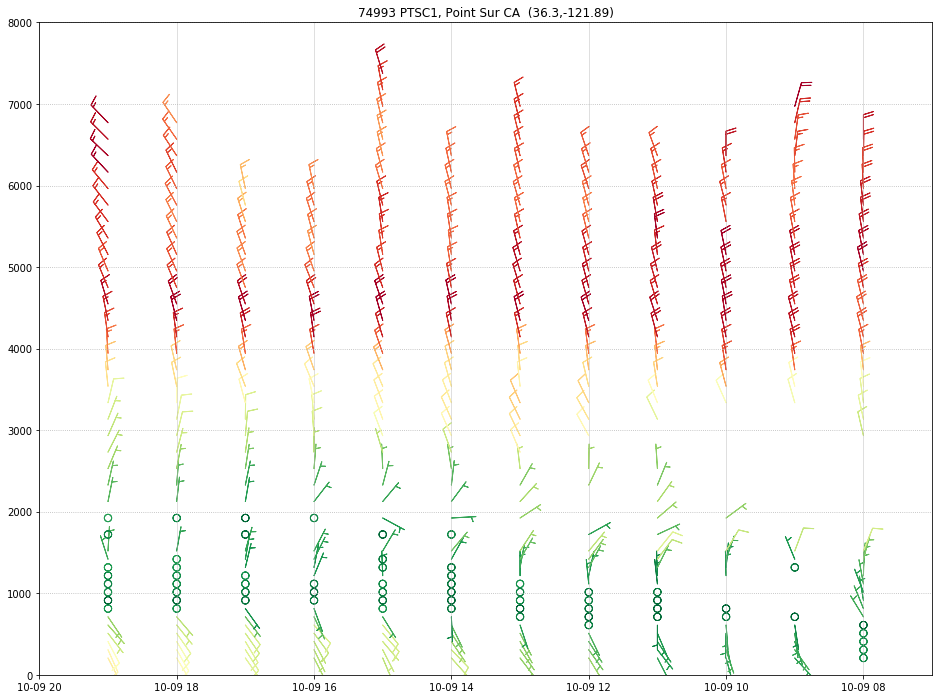

In [2]:
%matplotlib inline
fig = plt.figure(figsize=(16,12))
site = profilerSites[-1]

# Request the last twelve hourly obs
request = DataAccessLayer.newDataRequest("profiler")
request.setLocationNames(site)
request.setParameters("uComponent","vComponent")
hrs=12
requestTimes = DataAccessLayer.getAvailableTimes(request)[-1*hrs:]
response = DataAccessLayer.getGeometryData(request,requestTimes)

# Create a plot for each station
ax = fig.add_subplot(1,1,1)
ax.title.set_text(site +" "+ str(profiler[site]['profilerId']) \
    +", "+ str(profiler[site]['profilerName']) \
    +"  ("+ str(profiler[site]['latitude']) +","+ str(profiler[site]['longitude']) +")")
ax.set_ylim(0,8000)
ax.grid(axis='x', which='major', alpha=0.5)
ax.grid(axis='y', which='major', linestyle=':')
ax.xaxis_date()
ax.set_xlim(min(requestTimes).validPeriod.start-timedelta(hours=1), max(requestTimes).validPeriod.start+timedelta(hours=1))

# Plot profiler observations
for time in requestTimes:
    data,t=[],[]
    u,v=[],[]
    for ob in response:
        if str(ob.getDataTime().getValidPeriod().start) == str(time):
            data_tuple = (float(ob.getLevel().replace('FHAG','')),
                float(ob.getNumber("uComponent")),
                float(ob.getNumber("vComponent")))
            data.append(data_tuple)
            t.append(time.validPeriod.start)

    data = np.array(data, dtype=[
        ('h', np.float32),
        ('u', np.float32),
        ('v', np.float32)])

    u = data['u']
    v = data['v']
    h = data['h']
    C = np.sqrt(u**2 + v**2)
    ax.barbs(date2num(t), h, u, v, C, cmap=plt.cm.RdYlGn_r)

plt.gca().invert_xaxis()